# Convolutional Neural Networks

For this homework you will train a CNN on the Hymenoptera dataset that you can download from here:

- https://download.pytorch.org/tutorial/hymenoptera_data.zip

You will code any CNN architecture that you want for this, using pytorch and/or pytorch-lightning (you can use only pytorch is you want)

## Load the dataset

**QUESTION.** Load the dataset into two dataloaders, one from training and the other for validation.

- You can use `torchvision.datasets.ImageFolder` and pass it to `DataLoader` for this, have a look at the documentation
- In the transformations, you should resize the images to make things faster (using the size of CIFAR-10's images for instance), and use some data augmentation (only for the training dataloader, of course) 

**QUESTION.** Display some images and their associated labels. You should see images of bees and ants :)

In [154]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, ConcatDataset
import torchvision
import torchvision.transforms as transforms
import pdb
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

import multiprocessing

In [74]:
workers = multiprocessing.cpu_count()

# Simple validation in case we have a GPU available
gpu = -1 if torch.cuda.is_available() else 0

num_epochs = 20

In [99]:
data_dir = "hymenoptera_data"

#Applying Transformation
train_transforms = transforms.Compose([
    transforms.Resize((32,32), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomRotation(30),
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])


val_transforms = transforms.Compose([
    transforms.Resize((32,32), interpolation=transforms.InterpolationMode.BILINEAR),
    #transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [100]:
train_data = datasets.ImageFolder(data_dir + "/train", transform = train_transforms)                                       
val_data = datasets.ImageFolder(data_dir + "/val", transform = val_transforms)

In [96]:
print(train_data)
print(val_data)

Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear)
               ToTensor()
           )


In [161]:
#Data Loading
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, num_workers = workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4, num_workers = workers)

In [123]:
def show_images(img):
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.show()

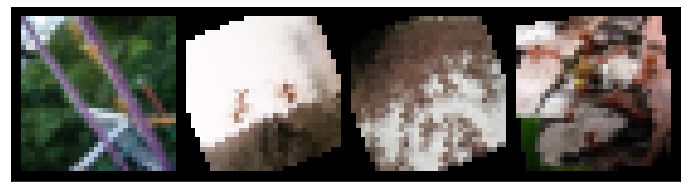

tensor([0, 0, 0, 0])


In [124]:
train_iter = iter(train_loader)
images, labels = next(train_iter)
show_images(torchvision.utils.make_grid(images))
print(labels)

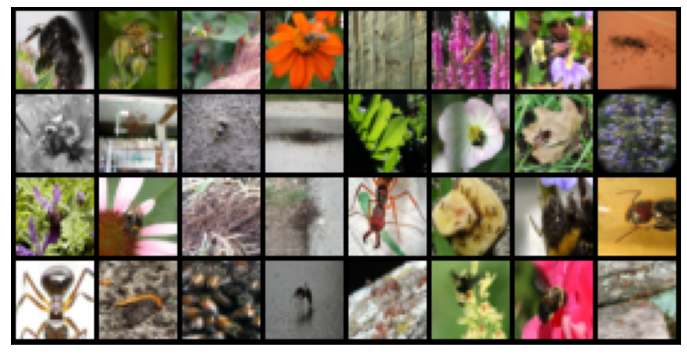

tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 0])


In [79]:
valid_iter = iter(val_loader)
images_valid, labels_valid = next(valid_iter)
show_images(torchvision.utils.make_grid(images_valid))
print(labels_valid)

## Neural net architecture

You are free to define any kind of convolutional neural network that you think is reasonable for today's problem.
Remember that convolutional neural networks are usually a combination of the following building blocks:

  * Convolutional layers
  * Pooling layers
  * Linear layers
  
It is your task today to arrange these components into a reasonable architecture.

In [102]:
class ConvNet(pl.LightningModule):

    def __init__(self, output_dim):

        super(ConvNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=600),
            nn.Dropout2d(0.2),
            nn.Linear(in_features=600, out_features=120),
            nn.Dropout2d(0.3),
            nn.Linear(in_features=120, out_features=output_dim)    
        )
        
        self.accuracy = pl.metrics.Accuracy()
            
    def forward(self, x):
        out = self.encoder(x)
        features = out.view(out.size(0), -1)
        logits = self.classifier(features)
        return logits
    
    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=1e-3)

## Training loop and checks

**QUESTION**. Code the training loop (specify the loss, etc.). Check that everything is fine, that the forward pass works and that training on a very small subset of the data works as well. Add the callbacks that you want, and prepare the logging tools that you want to use (such as tensorboard, or anything you want to use.

In [103]:
net = ConvNet(2)

In [104]:
x = torch.randn(1, 3, 32, 32)
out = net(x)
out.size()

torch.Size([1, 2])

In [105]:
print(out)

tensor([[-0.0232,  0.0744]], grad_fn=<AddmmBackward>)


In [106]:
print(net)

ConvNet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=600, bias=True)
    (1): Dropout2d(p=0.2, inplace=False)
    (2): Linear(in_features=600, out_features=120, bias=True)
    (3): Dro

In [107]:
# Initialize a trainer
trainer = pl.Trainer(gpus=gpu, progress_bar_refresh_rate=20, fast_dev_run=True)

# Train the model ⚡
trainer.fit(net, train_dataloader=train_loader, val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 287 K 
1 | classifier | Sequential | 380 K 
2 | accuracy   | Accuracy   | 0     
------------------------------------------
667 K     Trainable params
0         Non-trainable params
667 K     Total params
2.669     Total estimated model params size (MB)
/home/jlechuga/anaconda3/envs/deepmind/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


1

In [108]:
trainer = pl.Trainer(gpus=gpu, max_epochs=num_epochs, progress_bar_refresh_rate=20)
trainer.fit(net, train_dataloader=train_loader, val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 287 K 
1 | classifier | Sequential | 380 K 
2 | accuracy   | Accuracy   | 0     
------------------------------------------
667 K     Trainable params
0         Non-trainable params
667 K     Total params
2.669     Total estimated model params size (MB)


1

In [119]:
net.accuracy.compute()

tensor(0.5134)

## Measure the performance of you model

Measure the performance of your model, and display some things (such as confusion matrix, ROC or AUC curves).
Compare several architectures, put your results in an easy to interpret pandas dataframe.

In [134]:
from sklearn.metrics import (classification_report, roc_curve, precision_recall_curve, roc_auc_score, 
                             average_precision_score)

In [149]:
msg = "Classification report for Conv Network"
print(msg)
print("-" * len(msg))

report_simple = classification_report(val_data.targets, scores.argmax(1))
print(report_simple)

Classification report for Conv Network
--------------------------------------
              precision    recall  f1-score   support

           0       0.38      0.04      0.08        70
           1       0.54      0.94      0.68        83

    accuracy                           0.53       153
   macro avg       0.46      0.49      0.38       153
weighted avg       0.46      0.53      0.41       153



In [110]:
def get_predictions(model, loader):
    all_preds = torch.tensor([]).detach()
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds.detach()

In [112]:
# Note: we should increase the batch_size to compure pure forward predictions
predictions = get_predictions(net, val_loader)
scores = F.softmax(predictions, dim=1)

In [113]:
scores[:3].detach()

tensor([[0.4927, 0.5073],
        [0.4819, 0.5181],
        [0.4852, 0.5148]])

In [151]:
confusion_matrix = confusion_matrix(val_data.targets, scores.argmax(dim=1))
confusion_matrix

array([[ 3, 67],
       [ 5, 78]])

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

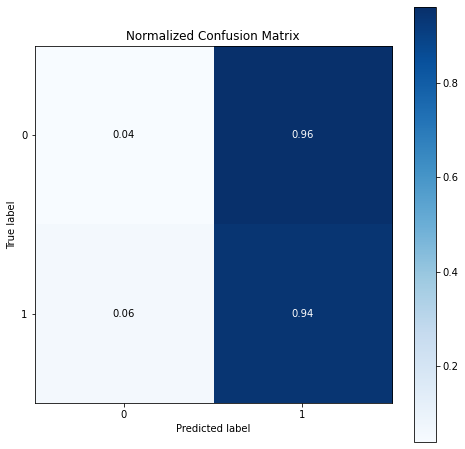

In [117]:
skplt.metrics.plot_confusion_matrix(val_data.targets, scores.argmax(dim=1), normalize=True, figsize=(8, 8))

In [155]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_roc_curve(y_test, y_score, title=None, label=None, legend=True, 
                   show_thresholds=True, colorbar=True):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    thresholds[0] = 1
    roc_auc = roc_auc_score(y_test, y_score)

    if label is None:
        label='ROC curve (area = %0.2f)' % roc_auc

    if title is None:
        title = "ROC curve"

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    
    if show_thresholds:
        norm = plt.Normalize(vmin=0, vmax=1)
        plt.plot(fpr, tpr, lw=1, label=label, alpha=0.7)
        plt.scatter(fpr, tpr, cmap=cm, c=thresholds, s=70, norm=norm)
        if colorbar:
            plt.colorbar()
    else:
        plt.plot(fpr, tpr, lw=3, label=label)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(title, fontsize=16)
    if legend:
        plt.legend(fontsize=12)

def plot_roc_curves(y_test, y_scores, labels, title=None, show_thresholds=True):
    for y_score, label in zip(y_scores, labels):
        plot_roc_curve(y_test, y_score, label=label, legend=False, 
                       show_thresholds=show_thresholds, colorbar=False)
    plt.legend(fontsize=12)
    if show_thresholds:
        plt.colorbar()
    if title is not None:
        plt.title(title, fontsize=16)     

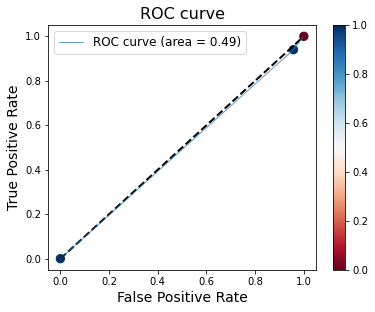

In [156]:
plt.figure(figsize=(6, 4.5))
plot_roc_curve(val_data.targets, scores.argmax(1))

In [157]:
def plot_pr_curve(y_test, y_score, title=None, label=None, legend=True, 
                   show_thresholds=True, colorbar=True):
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    precision = precision[:-1]
    recall = recall[:-1]
    avg_prec = average_precision_score(y_test, y_score)

    if label is None:
        label='PR curve (area = %0.2f)' % avg_prec

    if title is None:
        title = "PR curve"
    
    if show_thresholds:
        norm = plt.Normalize(vmin=0, vmax=1)
        plt.plot(recall, precision, lw=1, label=label, alpha=0.7)
        plt.scatter(recall, precision, cmap=cm, c=thresholds, s=70, norm=norm)
        if colorbar:
            plt.colorbar()
    else:
        plt.plot(recall, precision, lw=3, label=label)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title(title, fontsize=16)
    if legend:
        plt.legend(fontsize=12)

def plot_pr_curves(y_test, y_scores, labels, title=None, show_thresholds=True):
    for y_score, label in zip(y_scores, labels):
        plot_pr_curve(y_test, y_score, label=label, legend=False, 
                       show_thresholds=show_thresholds, colorbar=False)
    plt.legend(fontsize=12)
    if show_thresholds:
        plt.colorbar()
    if title is not None:
        plt.title(title, fontsize=16)   

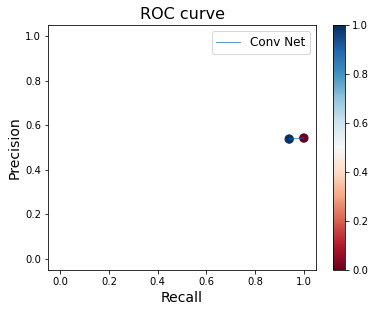

In [160]:
plt.figure(figsize=(6, 4.5))
plot_pr_curves(val_data.targets, [scores.argmax(1)], labels=["Conv Net"], title="ROC curve")

In [ ]:
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

## Use fine-tuning and transfer learning

You might have noticed that training a CNN from scratch can be very slow, hard, painful, and that the overall performance might not be satisfying. 

**QUESTION.** To overcome this, use a pre-trained network and fine-tune it on the Hymenoptera dataset.
You are free to choose any pre-trained model that the PyTorch library offers evaluate and compare its performance to the CNN you have built yourself.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

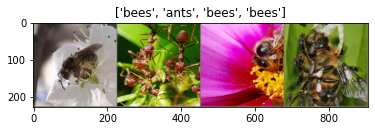

In [4]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6881 Acc: 0.5779
val Loss: 0.6751 Acc: 0.5752

Epoch 1/24
----------
train Loss: 0.6831 Acc: 0.5902
val Loss: 0.6818 Acc: 0.5882

Epoch 2/24
----------
train Loss: 0.6910 Acc: 0.5451
val Loss: 0.6765 Acc: 0.5752

Epoch 3/24
----------
train Loss: 0.6912 Acc: 0.5697
val Loss: 0.6774 Acc: 0.5817

Epoch 4/24
----------
train Loss: 0.6917 Acc: 0.5205
val Loss: 0.6705 Acc: 0.5556

Epoch 5/24
----------
train Loss: 0.6881 Acc: 0.5492
val Loss: 0.6712 Acc: 0.5556

Epoch 6/24
----------
train Loss: 0.6841 Acc: 0.5861
val Loss: 0.6773 Acc: 0.5752

Epoch 7/24
----------
train Loss: 0.6882 Acc: 0.5533
val Loss: 0.6812 Acc: 0.5817

Epoch 8/24
----------
train Loss: 0.6920 Acc: 0.5123
val Loss: 0.6697 Acc: 0.5621

Epoch 9/24
----------
train Loss: 0.6926 Acc: 0.5123
val Loss: 0.6713 Acc: 0.5686

Epoch 10/24
----------
train Loss: 0.6882 Acc: 0.5287
val Loss: 0.6756 Acc: 0.5882

Epoch 11/24
----------
train Loss: 0.6897 Acc: 0.5656
val Loss: 0.6819 Acc: 0.5752

Ep

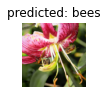

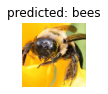

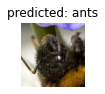

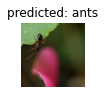

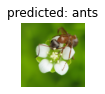

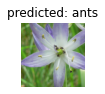

In [9]:
visualize_model(model_ft)

In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8673 Acc: 0.6107
val Loss: 0.2759 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.5212 Acc: 0.7705
val Loss: 0.1751 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4246 Acc: 0.7951
val Loss: 0.1818 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4352 Acc: 0.8238
val Loss: 0.4422 Acc: 0.8235

Epoch 4/24
----------
train Loss: 0.4572 Acc: 0.7910
val Loss: 0.2598 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.4063 Acc: 0.8361
val Loss: 0.3680 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.4976 Acc: 0.8074
val Loss: 0.1670 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3792 Acc: 0.8443
val Loss: 0.1670 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3503 Acc: 0.8402
val Loss: 0.1510 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3586 Acc: 0.8361
val Loss: 0.1773 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2857 Acc: 0.8852
val Loss: 0.1812 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3784 Acc: 0.8607
val Loss: 0.1767 Acc: 0.9412

Ep

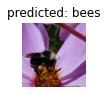

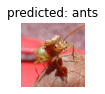

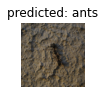

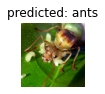

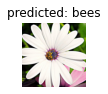

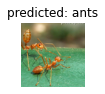

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()